## Setup

### Imports

In [1]:
import sys; sys.path.append('..')

In [2]:
# ! pip install lovely-tensors

import lovely_tensors as lt
lt.monkey_patch()

In [3]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformer_lens import HookedTransformer, HookedTransformerConfig

In [4]:
import wandb
from tqdm.auto import tqdm

from omegaconf import OmegaConf

from datetime import datetime

from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from src.tree import list2tree
from src.tree_dataset import TreeDataset, parse_input_idx, input_tokens_to_tree, tree_to_edges
from src.utils import seed_all


from src.trainer import TreeTrainer

### Read config

In [6]:
conf = OmegaConf.load('../conf/00_reproduce_6L_nodes=16.yaml')
# Output is identical to the YAML file
conf.n_nodes = 16
conf.device = 'cpu'
print(OmegaConf.to_yaml(conf))

random_seed: 42
n_nodes: 16
model:
  d_model: 128
  d_head: 128
  n_layers: 6
  act_fn: gelu
  attention_dir: causal
optimizer:
  lr: 0.001
  weight_decay: 0.01
batch_size: 64
epoch_len_steps: 5000
checkpoint_every_epoch: 2
device: cpu
debug: false
use_wandb: true
wandb:
  project: reasoning-mech-interp
  name: 00_6L_nodes=16
max_iters: null



### Constants (mostly derived)

In [7]:
REPRODUCED_MODEL_CKPT = '../checkpoints/reasoning-mech-interp__2024-04-10_16-10-20/00_6L_nodes=16__step=220000.pt'

In [8]:
DEV_RUN = True
USE_WANDB = (not DEV_RUN) and conf.use_wandb
device = conf.device

CHECKPOINT_ROOT = Path('../checkpoints')

In [9]:
def create_checkpoint_dir(conf):
    now = datetime.now()
    now_filename = now.strftime("%Y-%m-%d_%H-%M-%S")
    
    checkpoint_dir = CHECKPOINT_ROOT/f'{conf["wandb"]["project"]}__{now_filename}'
    checkpoint_dir.mkdir(exist_ok=True, parents = True)
    return checkpoint_dir

In [10]:
# if USE_WANDB:
#     wandb.init(project=conf.wandb.project, name=conf.wandb.name, config=OmegaConf.to_object(conf))

In [11]:
RANDOM_SEED = conf['random_seed']
print(f'{RANDOM_SEED=}')
seed_all(RANDOM_SEED)

RANDOM_SEED=42


In [12]:
trainer = TreeTrainer(conf)

Moving model to device:  cpu


In [13]:
tokenizer = trainer.dataset.tokenizer

tok = tokenizer.tokenize
detok = tokenizer.detokenize


ROOT_DELIM_TOKEN_IDX = trainer.tok([':'])[0]

## Simple Inference Setup

In [14]:
state_dict = torch.load(REPRODUCED_MODEL_CKPT)
trainer.model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
from src.tree_dataset import random_binary_tree


test_tree = random_binary_tree(16, seed=42)
test_tree

                       3
                       |
              +--------+-----------+
              |                    |
              0                    8
              |                    |
  +-----------+-----+        +-----+--------+
  |                 |        |              |
 11                 2       12              6
  |                 |        |              |
  +--------+     +--+     +--+--+     +-----+--+
           |     |        |     |     |        |
           4     1       10    14     5        7
           |                          |
     +-----+                          +--+
     |                                   |
    15                                   9
     |
     +--+
        |
       13

In [16]:
tree = test_tree

In [17]:
from src.tree_dataset import create_tree_path, create_input_idx

def inference(prompt_tokens):
    idx = trainer.tok(prompt_tokens)
    
    input_idx = torch.tensor(idx)[None]
    pred_idx_greedy = trainer.model(input_idx)[0, -1].argmax()
    
    pred_token = trainer.detok([pred_idx_greedy])[0]
    return pred_token

In [18]:
prompt_tokens, path_tokens = create_tree_path(test_tree, goal=4)
print(f'{path_tokens=}')
sample = create_input_idx(prompt_tokens, path_tokens, tokenizer)
input_idx = sample['input_idx']

sample

path_tokens=['→0', '→11', '→4']


{'input_idx': tensor[68] i64 x∈[0, 35] μ=9.485 σ=10.970,
 'task_mask': tensor[68] bool x∈[False, True] μ=0.044 σ=0.207}

In [19]:
autoregressive_prompt = prompt_tokens
predicted_tokens = []


for _ in range(10):
    pred_token = inference(autoregressive_prompt)
    predicted_tokens.append(pred_token)
    print(f'{pred_token=}')
    autoregressive_prompt.append(pred_token)

pred_token='→0'
pred_token='→11'
pred_token='→4'
pred_token='→0'
pred_token='→11'
pred_token='→4'
pred_token='→4'
pred_token='→4'
pred_token='→4'
pred_token='→4'


## baseline ("their") model

In [20]:
# ! wget https://github.com/abhay-sheshadri/backward-chaining-circuits/raw/main/model.pt -P ../checkpoints

In [21]:
n_states = 16
max_seq_length = n_states * 4 + 2

number_tokens = sorted([str(i) for i in range(n_states)], key=lambda x: len(x), reverse=True)
idx2tokens = [",", ":", "|"] + [f">{t}" for t in number_tokens] + number_tokens
tokens2idx = {token: idx for idx, token in enumerate(idx2tokens)}

In [22]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(idx2tokens),
    device=device,
    attention_dir= "causal",
    act_fn="gelu",
)

baseline_model = HookedTransformer(cfg)

In [23]:
state_dic = torch.load('../checkpoints/model.pt', map_location=torch.device(device))
baseline_model.load_state_dict(state_dic)

<All keys matched successfully>

## EDA Directions

In [24]:
def plot_QK(model, title_prefix='', QK_i=0, ):
    scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
    for q in range(model.cfg.n_ctx):
        for k in range(model.cfg.n_ctx):
            q_out = model.blocks[QK_i].ln1( model.W_pos[q:q+1] ) @ model.blocks[QK_i].attn.W_Q[0] + model.blocks[QK_i].attn.b_Q
            k_out = model.blocks[QK_i].ln1( model.W_pos[k:k+1] ) @ model.blocks[QK_i].attn.W_K[0] + model.blocks[QK_i].attn.b_K
            
            if k < q:
                scores[q, k] = q_out @ k_out.T
    
    
    plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
    plt.title(title_prefix+'$QK_{QK_i}$'.replace('QK_i', str(QK_i)))
    plt.ylabel("Position Embedding in Query")
    plt.xlabel("Position Embedding in Key")

### Small models QK plot

#### `01_2L_nodes=16`

In [25]:
conf = OmegaConf.load('../conf/01_reproduce_2L.yaml')
conf.device='cpu'
trainer_small_01_2L = TreeTrainer(conf)

Moving model to device:  cpu


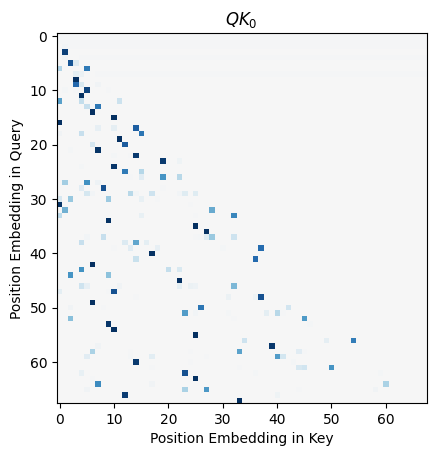

In [26]:
plot_QK(trainer_small_01_2L.model)

 - [ ] Understand how it behaves on trees of unseen sizes
 - [ ] Use their mechanism search tools/interventions on their+on reproduced model

### Verify "Edge Token Concatenation Head" hypothesis

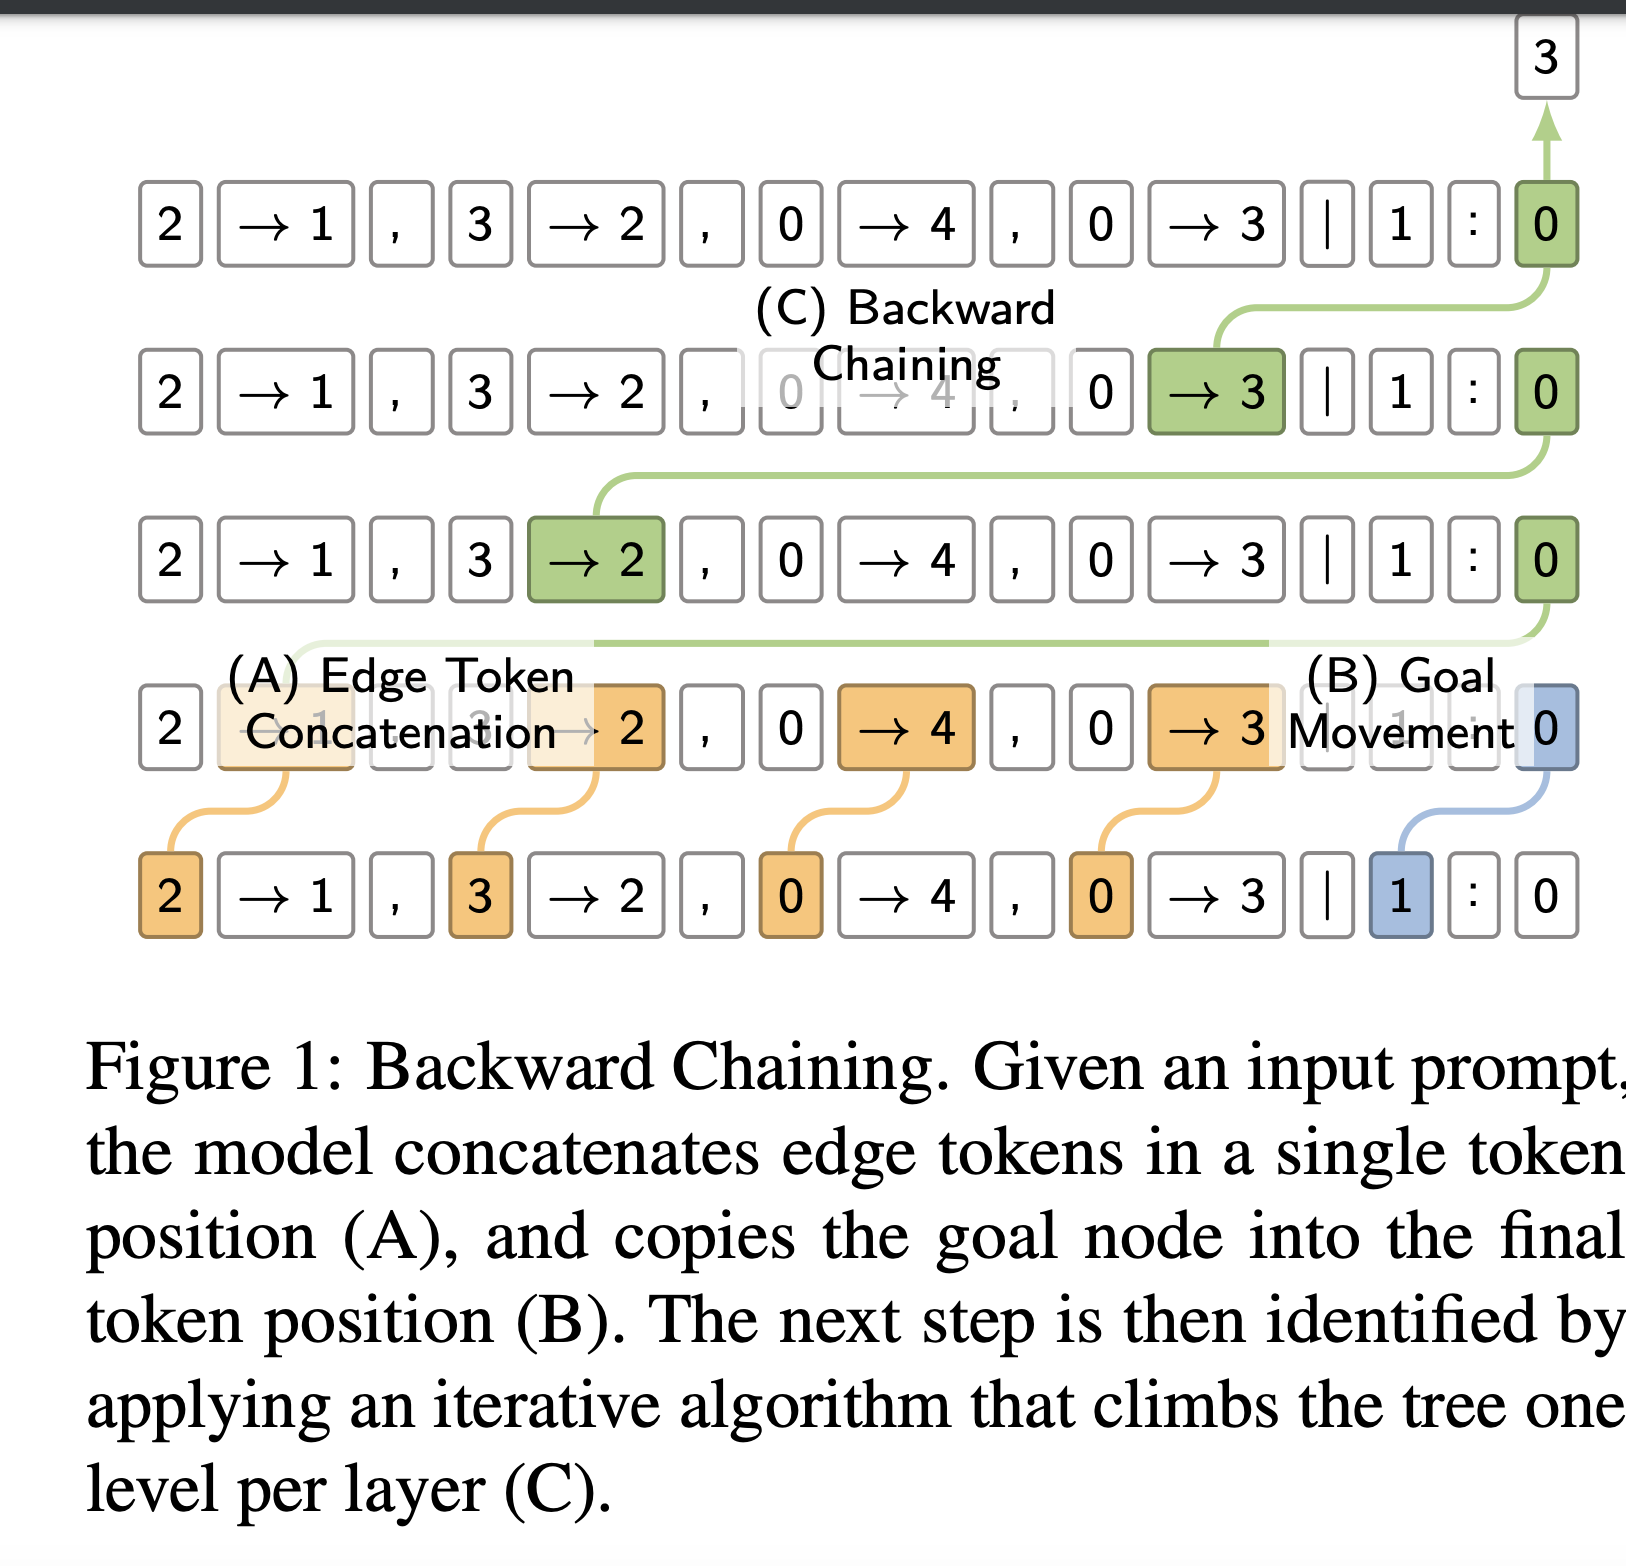

In [27]:
test_tree = random_binary_tree(16, seed=42)
test_tree

                       3
                       |
              +--------+-----------+
              |                    |
              0                    8
              |                    |
  +-----------+-----+        +-----+--------+
  |                 |        |              |
 11                 2       12              6
  |                 |        |              |
  +--------+     +--+     +--+--+     +-----+--+
           |     |        |     |     |        |
           4     1       10    14     5        7
           |                          |
     +-----+                          +--+
     |                                   |
    15                                   9
     |
     +--+
        |
       13

In [28]:
prompt_tokens, path_tokens = create_tree_path(test_tree, goal=9)
print(f'{path_tokens=}')
sample = create_input_idx(prompt_tokens, path_tokens, tokenizer)
input_idx = sample['input_idx']

sample

path_tokens=['→8', '→6', '→5', '→9']


{'input_idx': tensor[68] i64 x∈[0, 35] μ=10.088 σ=11.037,
 'task_mask': tensor[68] bool x∈[False, True] μ=0.059 σ=0.237}

In [29]:
autoregressive_prompt = prompt_tokens
predicted_tokens = []


for _ in range(10):
    pred_token = inference(autoregressive_prompt)
    predicted_tokens.append(pred_token)
    print(f'{pred_token=}')
    autoregressive_prompt.append(pred_token)

pred_token='→8'
pred_token='→6'
pred_token='→5'
pred_token='→9'
pred_token='→12'
pred_token='→10'
pred_token='→12'
pred_token='→10'
pred_token='→12'
pred_token='→10'


In [30]:
model = trainer.model

#### plot QK

In [31]:
def load_model(device='cpu'):
    n_states = 16
    max_seq_length = n_states * 4 + 2
    
    number_tokens = sorted([str(i) for i in range(n_states)], key=lambda x: len(x), reverse=True)
    idx2tokens = [",", ":", "|"] + [f">{t}" for t in number_tokens] + number_tokens
    tokens2idx = {token: idx for idx, token in enumerate(idx2tokens)}
    
    
    cfg = HookedTransformerConfig(
        n_layers=6,
        d_model=128,
        n_ctx=max_seq_length - 1,
        n_heads=1,
        d_mlp=512,
        d_head=128,
        #attn_only=True,
        d_vocab=len(idx2tokens),
        device=device,
        attention_dir= "causal",
        act_fn="gelu",
    )
    model = HookedTransformer(cfg)
    
    model.load_state_dict(torch.load("/Users/mykhailokilianovskyi/src/backward-chaining-circuits/model.pt", map_location=torch.device(device)))
    
    return model

In [32]:
baseline_model = load_model()

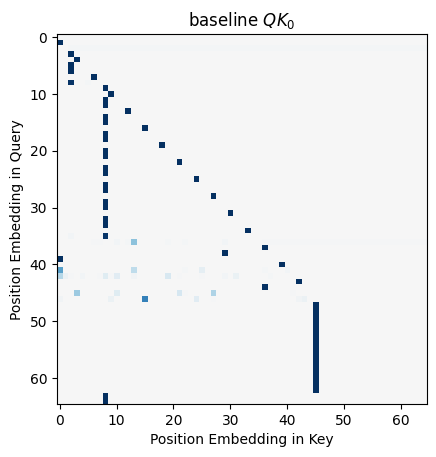

In [33]:
plot_QK(baseline_model, 'baseline ')

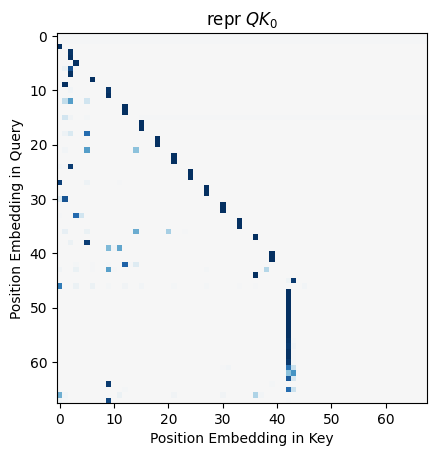

In [34]:
plot_QK(trainer.model, 'repr ')

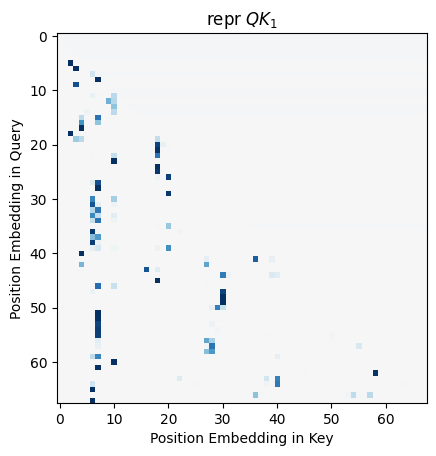

In [35]:
plot_QK(trainer.model, 'repr ', 1)

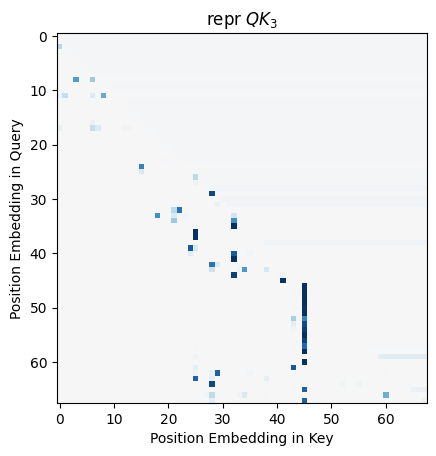

In [36]:
plot_QK(trainer.model, 'repr ', 3)

#### Linear Probes

### Different 

> Spend some time just inputting text into the data and inspecting the output, editing the text and seeing how the model's output changes, and exploring the problem.


> Importantly, try to find inputs where the model *doesn’t* do the task - it’s easy to have an elaborate and sophisticated hypothesis explaining a simple behaviour.

In [39]:
for batch in trainer.dataloader:
    break

In [48]:
trainer.print_sample_pred(batch['input_idx'][0])

****************************************************************************************************
     5
     |
  +--+-----------------------------------+
  |                                      |
 11                                      6
                                         |
                 +-----------------------+-----+
                 |                             |
                15                             8
                 |                             |
              +--+--------+                 +--+
              |           |                 |
             13           4                14
              |           |
           +--+        +--+-----------+
           |           |              |
          10           0              2
           |           |              |
        +--+        +--+        +-----+
        |           |           |
        7           9           3
                                |
                             +--+--+
         

In [52]:
import pandas as pd

In [54]:
self = trainer

In [56]:
input_idx = batch['input_idx'].to(self.device)
mask = batch['task_mask'].to(self.device)

inputs = input_idx[:, :-1]

out_mask = mask[:, 1:]
targets = input_idx[:, 1:][out_mask]


# print(input_idx[:1, :4])
outputs = self.model(inputs)

predictions = outputs[out_mask]

loss = F.cross_entropy(predictions, targets)


is_correct = (predictions.argmax(dim=-1) == targets)
accuracy_mean = is_correct.float().mean()

In [64]:
out_mask

tensor[64, 67] bool n=4288 (4.2Kb) x∈[False, True] μ=0.060 σ=0.237

In [65]:
input_idx[:, 1:]

tensor[64, 67] i64 n=4288 (34Kb) x∈[0, 35] μ=10.360 σ=11.504

In [88]:
accuracy_by_depth(outputs, input_idx, out_mask)

{'acc_depth=1': 1.0,
 'acc_depth=2': 1.0,
 'acc_depth=3': 1.0,
 'acc_depth=4': 1.0,
 'acc_depth=5': 0.9090909090909091,
 'acc_depth=6': 0.75,
 'acc_depth=7': 0.0,
 'acc_depth=8': 1.0,
 'acc_depth=9': 1.0}

In [47]:
detok(batch['input_idx'][0] [batch['task_mask'][0]])

['→6', '→8', '→14']

In [44]:
()

tensor[68] bool x∈[False, True] μ=0.044 σ=0.207

In [41]:
batch['input_idx']

tensor[64, 68] i64 n=4352 (34Kb) x∈[0, 35] μ=10.493 σ=11.527

In [37]:
test_tree = random_binary_tree(16, seed=42)

In [38]:
test_tree

                       3
                       |
              +--------+-----------+
              |                    |
              0                    8
              |                    |
  +-----------+-----+        +-----+--------+
  |                 |        |              |
 11                 2       12              6
  |                 |        |              |
  +--------+     +--+     +--+--+     +-----+--+
           |     |        |     |     |        |
           4     1       10    14     5        7
           |                          |
     +-----+                          +--+
     |                                   |
    15                                   9
     |
     +--+
        |
       13